In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import  CosineAnnealingLR
from neuralforecast.models import NBEATSx, NBEATS
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import HuberLoss
from sktime.transformations.series.vmd import VmdTransformer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import logging

logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

## Configure VMD and Model Specification

In [65]:
# Number of modes (view national as aggregate)
K = 60
K1 = 60 # County level VMD modes

# Model Configuration
lookback = 5
horizon = 2

# Training Parameters
num_epocs = 500
lr = 0.0008

## Using VMD Modes As Exogenous Features

In [66]:
# read data
df = pd.read_csv('data/chickenpox_raw.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').set_index('Date')
df['infections'] = df[df.columns].sum(axis=1)
df = df[['infections']]

# conduct VMD
transformer = VmdTransformer(K=K)
df_vmd = transformer.fit_transform(df)
residual = df['infections'].values - df_vmd.values.sum(axis=1)

# prepare data for training
data = df.copy()
data['ds'] = data.index
data['y'] = data['infections']
data['unique_id'] = 'chickenpox'
features = [f'mode_{i+1}' for i in range(df_vmd.shape[1])] + ['residual']
data['residual'] = residual
for i in range(df_vmd.shape[1]):
    data[f'mode_{i+1}'] = df_vmd.iloc[:, i].values

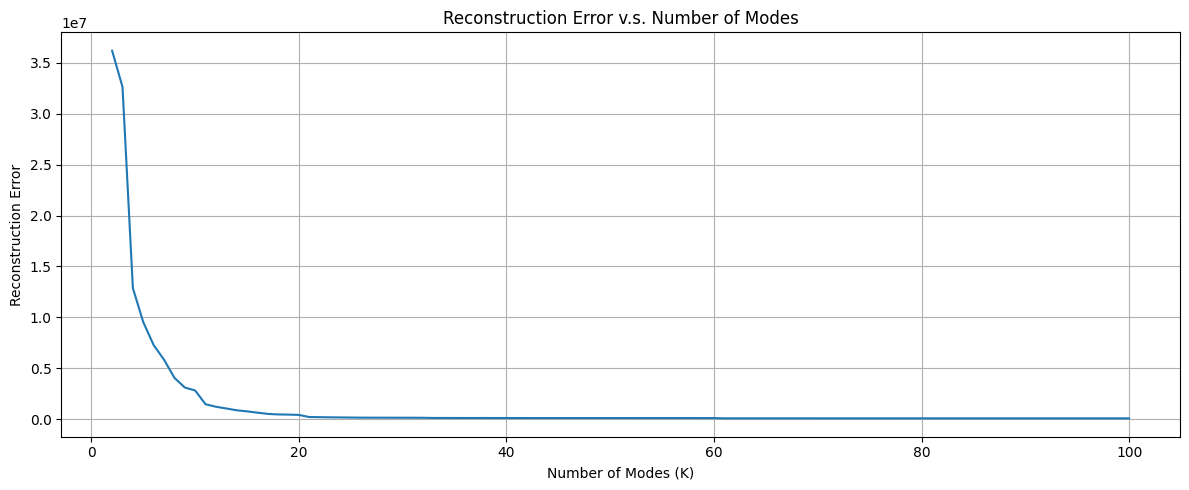

In [67]:
recon_err = []
Ks = [k for k in range(2, 101)]

for k in Ks:
    transformer = VmdTransformer(K=k)
    df_vmd = transformer.fit_transform(df)
    residual = df['infections'].values - df_vmd.values.sum(axis=1)
    err = np.sum(residual**2)
    recon_err.append(err)

plt.figure(figsize=(12, 5))
plt.plot(Ks, recon_err)
plt.xlabel('Number of Modes (K)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error v.s. Number of Modes')
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
model = NBEATSx(
    input_size=lookback,
    h=horizon,
    max_steps=num_epocs,
    stack_types=['seasonality', 'trend', 'identity', 'identity'],
    n_blocks=[4, 6, 4, 4],
    mlp_units=[[256, 512], [512, 512], [512, 256], [256, 256]],
    loss=HuberLoss(),
    valid_loss=HuberLoss(),
    optimizer=torch.optim.Adam,
    learning_rate=lr,
    lr_scheduler=CosineAnnealingLR,
    lr_scheduler_kwargs={'T_max': num_epocs, 'eta_min': 1e-5},
    futr_exog_list=features,
    random_seed=42,
    logger=False,
    enable_progress_bar=False
)
m = NeuralForecast(models = [model], freq='W')
m.fit(df=data, val_size=100, verbose=0)

Seed set to 42


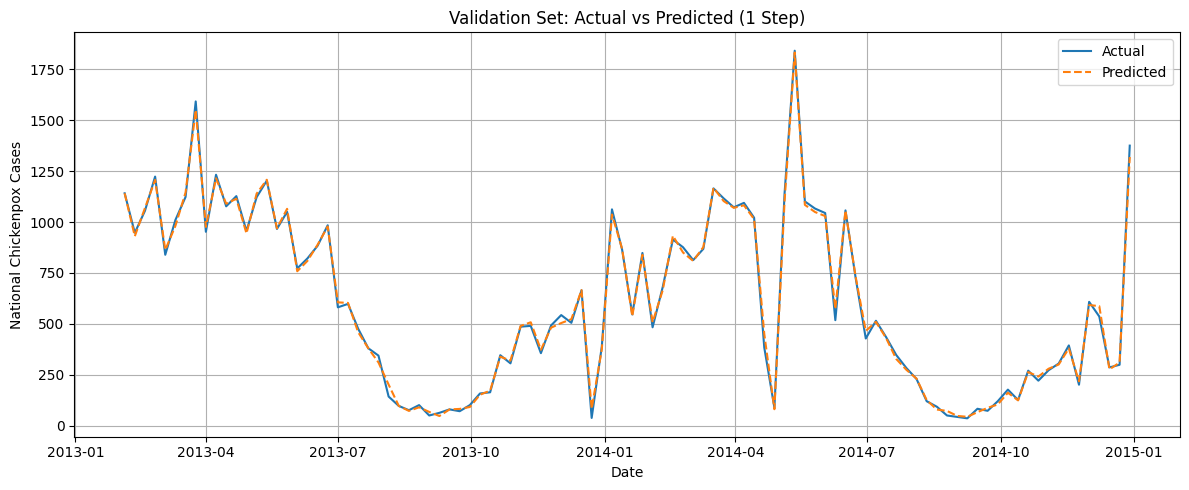

MAE: 15.467229843139648
RMSE: 20.500789642333984
MAPE: 0.064944326877594


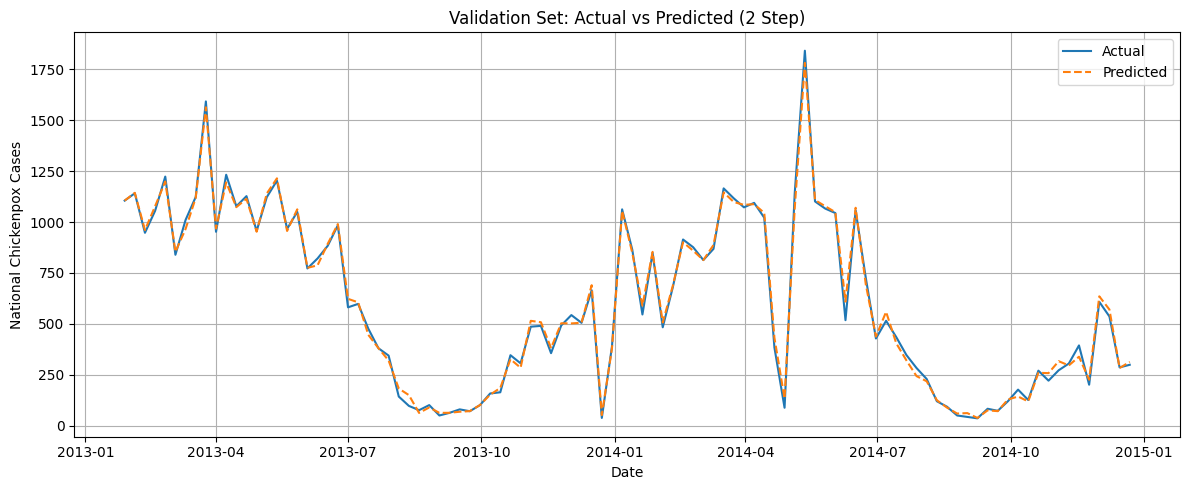

MAE: 19.516036987304688
RMSE: 25.805110931396484
MAPE: 0.06797707825899124


In [69]:
fitted = m.predict_insample().rename(columns={'NBEATSx': 'Predicted', 'y': 'Actual'})
fitted = fitted.sort_values(by=['ds', 'cutoff'], ascending=[True, True])
fitted['horizon'] = fitted.groupby('ds').cumcount(ascending=False)

for n_steps in range(horizon):
    val_comparison = fitted[fitted['horizon'] == n_steps].tail(100)

    plt.figure(figsize=(12, 5))
    plt.plot(val_comparison['ds'], val_comparison['Actual'], label='Actual')
    plt.plot(val_comparison['ds'], val_comparison['Predicted'], label='Predicted', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('National Chickenpox Cases')
    plt.title(f'Validation Set: Actual vs Predicted ({n_steps+1} Step)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    mae = mean_absolute_error(val_comparison['Actual'], val_comparison['Predicted'])
    rmse = root_mean_squared_error(val_comparison['Actual'], val_comparison['Predicted'])
    mape = mean_absolute_percentage_error(val_comparison['Actual'], val_comparison['Predicted'])
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')

## Predict Each Mode Seperately

In [70]:
long_df_list = []
for i in range(df_vmd.shape[1]):
    mode = df_vmd.iloc[:, i].values
    df_mode = pd.DataFrame({
        'unique_id': f'mode_{i+1}',
        'ds': data['ds'],
        'y': mode
    })
    long_df_list.append(df_mode)

residual_df = pd.DataFrame({
    'unique_id': 'mode_residual',
    'ds': data['ds'],
    'y': residual
})
long_df_list.append(residual_df)

long_df = pd.concat(long_df_list, axis=0, ignore_index=True).reset_index()

In [71]:
model = NBEATS(
        input_size=lookback,
        h=horizon,
        max_steps=num_epocs,
        stack_types=['seasonality', 'trend', 'identity'],
        n_blocks=[6, 6, 6],
        mlp_units=[[256, 512], [512, 512], [512, 256]],
        loss=HuberLoss(),
        valid_loss=HuberLoss(),
        optimizer=torch.optim.Adam,
        learning_rate=lr,
        lr_scheduler=CosineAnnealingLR,
        lr_scheduler_kwargs={'T_max': num_epocs, 'eta_min': 1e-5},
        random_seed=42,
        logger=False,
        enable_progress_bar=False
)
nf = NeuralForecast(models=[model], freq='W')
nf.fit(df=long_df, val_size=100, verbose=0)

Seed set to 42


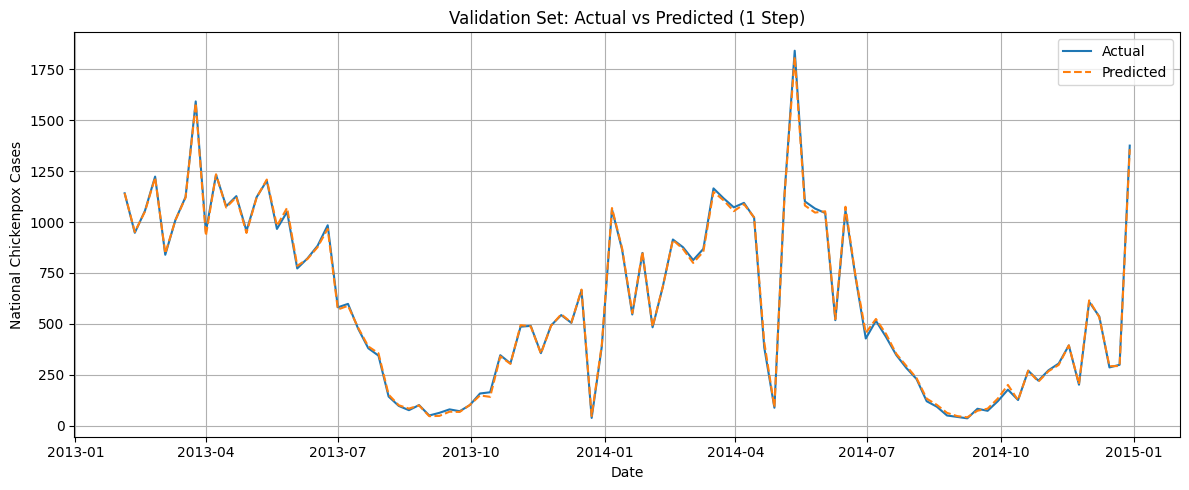

MAE: 8.323399543762207
RMSE: 10.519927978515625
MAPE: 0.03387535735964775


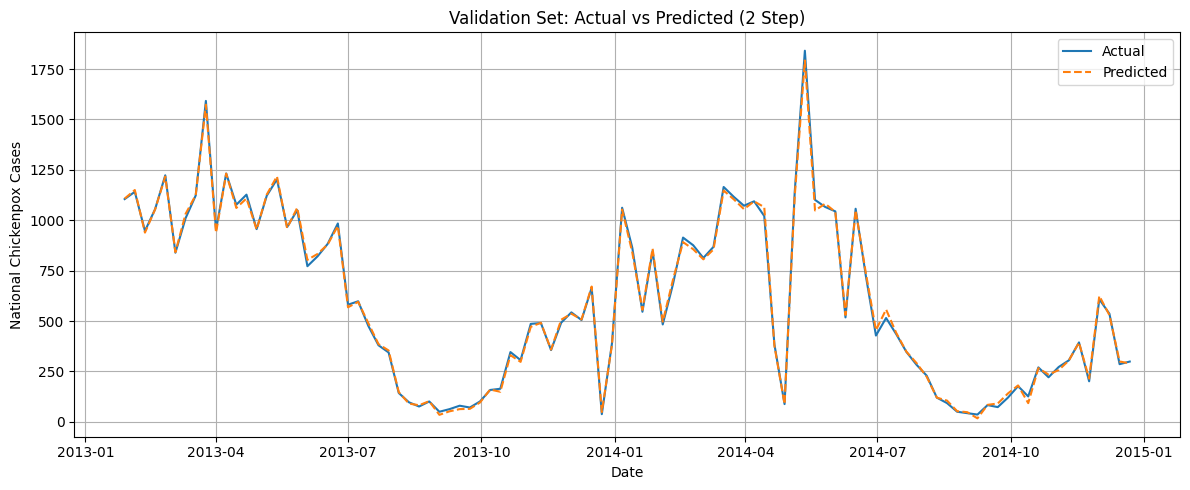

MAE: 11.664730072021484
RMSE: 15.44731616973877
MAPE: 0.044476911425590515


In [72]:
fitted = nf.predict_insample()
preds= fitted.pivot(index=['ds', 'cutoff'], columns='unique_id', values='NBEATS').reset_index()
actuals = fitted.pivot(index=['ds', 'cutoff'], columns='unique_id', values='y').reset_index()

cols = [col for col in preds.columns if col.startswith('mode_')]
fitted = pd.DataFrame(
    {
        'ds': preds['ds'],
        'cutoff': preds['cutoff'],
        'Predicted': preds[cols].sum(axis=1),
        'Actual': actuals[cols].sum(axis=1)
    }
)

fitted = fitted.sort_values(by=['ds', 'cutoff'], ascending=[True, True])
fitted['horizon'] = fitted.groupby('ds').cumcount(ascending=False)

for n_steps in range(horizon):
    val_comparison = fitted[fitted['horizon'] == n_steps].tail(100)

    plt.figure(figsize=(12, 5))
    plt.plot(val_comparison['ds'], val_comparison['Actual'], label='Actual')
    plt.plot(val_comparison['ds'], val_comparison['Predicted'], label='Predicted', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('National Chickenpox Cases')
    plt.title(f'Validation Set: Actual vs Predicted ({n_steps+1} Step)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    mae = mean_absolute_error(val_comparison['Actual'], val_comparison['Predicted'])
    rmse = root_mean_squared_error(val_comparison['Actual'], val_comparison['Predicted'])
    mape = mean_absolute_percentage_error(val_comparison['Actual'], val_comparison['Predicted'])
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')

## Apply VMD To Each County and Precict Each Mode Seperately

In [73]:
df = pd.read_csv('data/chickenpox_raw.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').set_index('Date')

df_list = []
transformer = VmdTransformer(K=K1)
for col in df.columns:
    temp = transformer.fit_transform(df[col])
    residual_df = pd.DataFrame({
        'unique_id': f'mode_residual_{col}',
        'ds': df.index,
        'y': df[col].values - temp.values.sum(axis=1)
    })
    df_list.append(residual_df)

    for i in range(K1):
        temp_df = pd.DataFrame({
            'unique_id': f'mode_{col}_{i+1}',
            'ds': df.index,
            'y': temp.iloc[:, i].values
        })
        df_list.append(temp_df)
data = pd.concat(df_list, axis=0, ignore_index=True)


In [74]:
model = NBEATS(
        input_size=lookback,
        h=horizon,
        max_steps=num_epocs,
        stack_types=['seasonality', 'trend', 'identity'],
        n_blocks=[6, 6, 6],
        mlp_units=[[256, 512], [512, 512], [512, 256]],
        loss=HuberLoss(),
        valid_loss=HuberLoss(),
        optimizer=torch.optim.Adam,
        learning_rate=lr,
        lr_scheduler=CosineAnnealingLR,
        lr_scheduler_kwargs={'T_max': num_epocs, 'eta_min': 1e-5},
        random_seed=42,
        logger=False,
        enable_progress_bar=False
)
nf = NeuralForecast(models=[model], freq='W')
nf.fit(df=data, val_size=100, verbose=0)

Seed set to 42


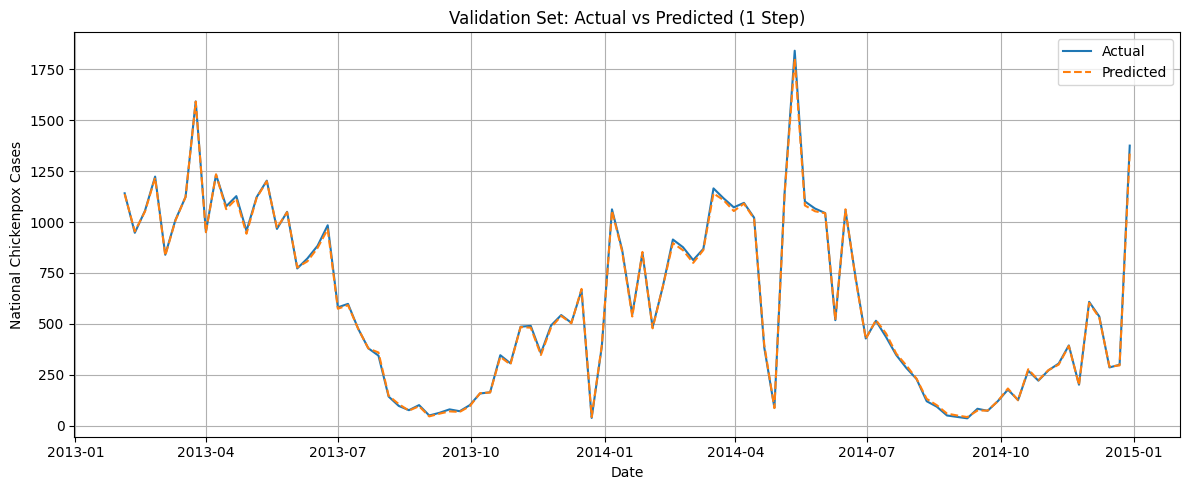

MAE: 7.070860385894775
RMSE: 9.513575553894043
MAPE: 0.024881241843104362


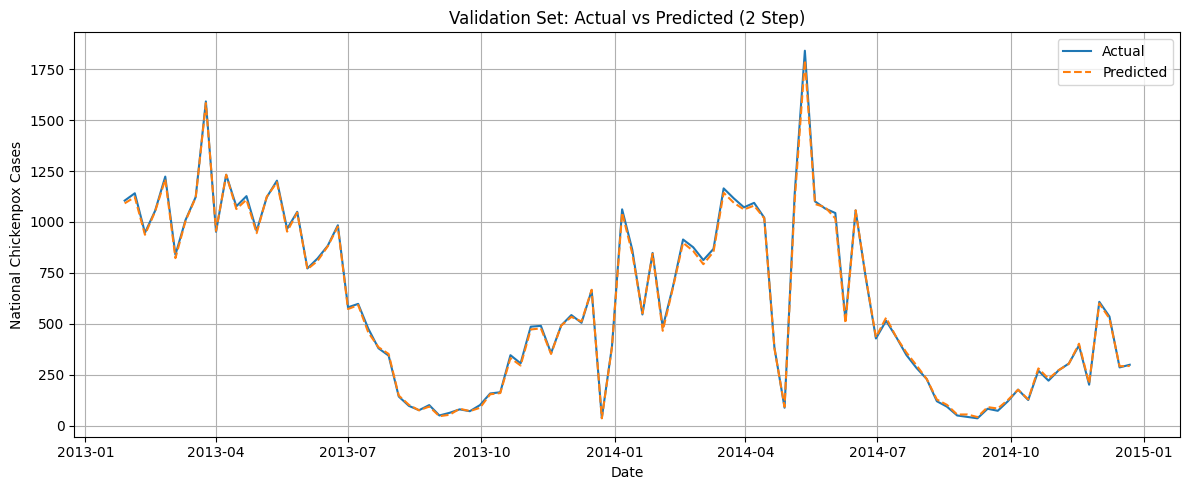

MAE: 9.152070045471191
RMSE: 11.751999855041504
MAPE: 0.029635608196258545


In [75]:
fitted = nf.predict_insample()
preds= fitted.pivot(index=['ds', 'cutoff'], columns='unique_id', values='NBEATS').reset_index()
actuals = fitted.pivot(index=['ds', 'cutoff'], columns='unique_id', values='y').reset_index()

cols = [col for col in preds.columns if col.startswith('mode_')]
fitted = pd.DataFrame(
    {
        'ds': preds['ds'],
        'cutoff': preds['cutoff'],
        'Predicted': preds[cols].sum(axis=1),
        'Actual': actuals[cols].sum(axis=1)
    }
)

fitted = fitted.sort_values(by=['ds', 'cutoff'], ascending=[True, True])
fitted['horizon'] = fitted.groupby('ds').cumcount(ascending=False)

for n_steps in range(horizon):
    val_comparison = fitted[fitted['horizon'] == n_steps].tail(100)

    plt.figure(figsize=(12, 5))
    plt.plot(val_comparison['ds'], val_comparison['Actual'], label='Actual')
    plt.plot(val_comparison['ds'], val_comparison['Predicted'], label='Predicted', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('National Chickenpox Cases')
    plt.title(f'Validation Set: Actual vs Predicted ({n_steps+1} Step)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    mae = mean_absolute_error(val_comparison['Actual'], val_comparison['Predicted'])
    rmse = root_mean_squared_error(val_comparison['Actual'], val_comparison['Predicted'])
    mape = mean_absolute_percentage_error(val_comparison['Actual'], val_comparison['Predicted'])
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')

## ARIMA Model As Baseline

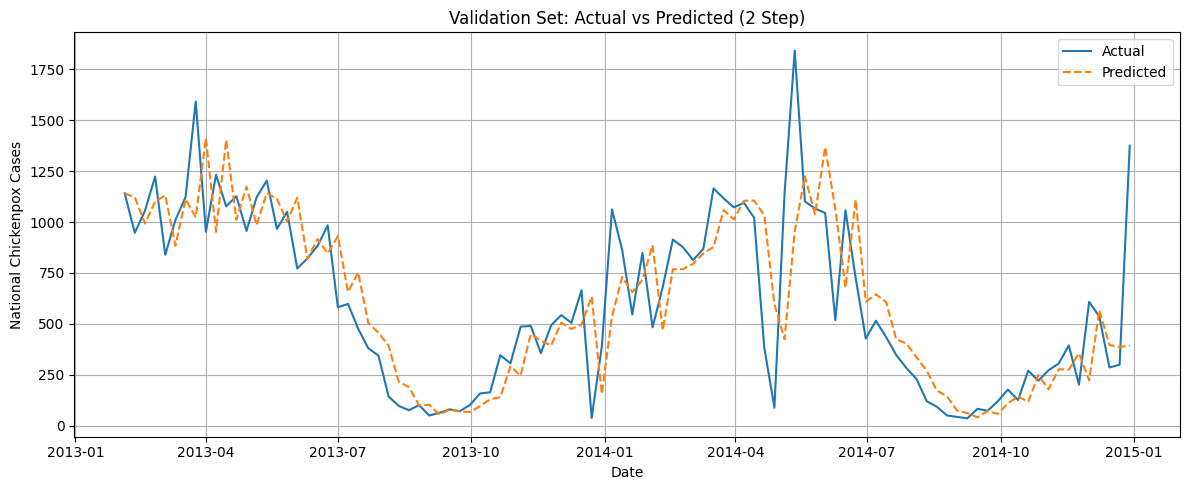

In [76]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

df = pd.read_csv('data/chickenpox_raw.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').set_index('Date')
df['infections'] = df[df.columns].sum(axis=1)
df = df[['infections']]
df['ds'] = df.index
df.rename(columns={'infections': 'y'}, inplace=True)
df['unique_id'] = 'chickenpox'
df_train = df.iloc[:-100]
df_test = df.iloc[-100:]

model = AutoARIMA()
sf = StatsForecast(models=[model], freq='W')
sf.fit(df=df_train)

y_hat = sf.forecast(df=df_test, h=1, fitted=True)
fitted = sf.forecast_fitted_values()
fitted = fitted.rename(columns={'y': 'Actual', 'AutoARIMA': 'Predicted'})
val_comparison = fitted.tail(100)

plt.figure(figsize=(12, 5))
plt.plot(val_comparison['ds'], val_comparison['Actual'], label='Actual')
plt.plot(val_comparison['ds'], val_comparison['Predicted'], label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('National Chickenpox Cases')
plt.title(f'Validation Set: Actual vs Predicted ({n_steps+1} Step)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
mae = mean_absolute_error(val_comparison['Actual'], val_comparison['Predicted'])
rmse = root_mean_squared_error(val_comparison['Actual'], val_comparison['Predicted'])
mape = mean_absolute_percentage_error(val_comparison['Actual'], val_comparison['Predicted'])
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MAE: 173.80955505371094
RMSE: 259.26171875
MAPE: 0.5763177871704102
